# GAN for Gravitational Lensing Images

In [1]:
#Imports
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision
from torchmetrics.image.fid import FrechetInceptionDistance
from torch.utils.data import Dataset

import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

torch.manual_seed(0)
from tqdm.notebook import tqdm
import opendatasets as od

import matplotlib.pyplot as plt

In [2]:
import os

DATA_DIR = '/home/babby/GSOC2024/Data/Model_II/cdm'
#print(os.listdir(DATA_DIR))

In [3]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

#### Image Resizing

In [4]:
image_size = 64 #image size for cropping the pics
batch_size = 64
latent_size = 64
#stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)  #parameters for normalizing the data
#normalize the pixel values with a mean & standard deviation of 0.5 for each channel. 
#This will ensure that pixel values are in the range (-1, 1)

### Object for image resizing

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, max_samples=10000, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = [f for f in os.listdir(root_dir) if f.endswith('.npy')]
        self.file_list = self.file_list[:max_samples]

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.root_dir, file_name)
        data = np.load(file_path, allow_pickle=True)
        data = (data - np.min(data))/(np.max(data)-np.min(data))
        data = torch.from_numpy(data).float()
        data = data.unsqueeze(0)
        if self.transform:
            data = self.transform(data)

        return data

In [6]:
# Load the Dataset
dataset = CustomDataset(root_dir=DATA_DIR)
train_dl = DataLoader(dataset=dataset, batch_size=batch_size , shuffle=True)

In [7]:
# train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
#     T.Resize(image_size),
#     T.CenterCrop(image_size),
#     T.ToTensor(),
#     T.Normalize(*stats)]))

# train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [8]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

## Showing some Images from our dataset

In [9]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [10]:
def show_images(x_sampled, nmax=64):
    grid = make_grid(x_sampled, nrow=10)
    plt.figure(figsize=(10,10))
    plt.imshow(grid.permute(1,2,0).detach().numpy())

def show_batch(dl, nmax=64):
    for images in dl:
        show_images(images, nmax)
        break

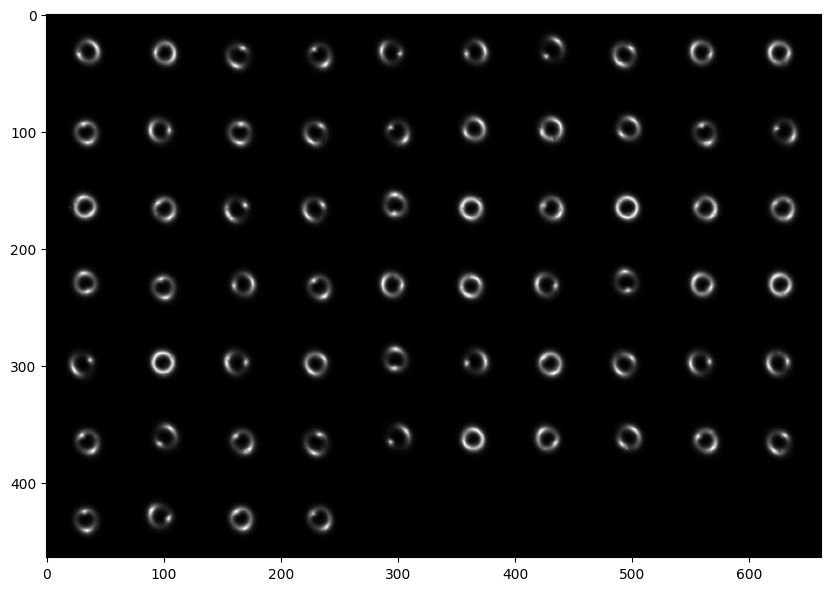

In [11]:
show_batch(train_dl)

### GPU avilablity functions

In [12]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

## Utils

In [13]:
#Helper sample function - generates and plots our generated images into 10*10 grid

def sample(model = None, checkpoint = None, device=None, n=100,**kwargs):

    if checkpoint is not None:
        model.load_state_dict(torch.load(checkpoint))
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"

    model.eval()
    model.to(device)
    with torch.no_grad():
        torch.manual_seed(0)
        z = torch.randn(n, latent_size).to(device) / 2
        z = torch.randn((n, latent_size, 1, 1), device = device)

        x_sampled = model(z)
        x_sampled = x_sampled.cpu() # n, nc, 128, 128

        plot_fig(x_sampled,**kwargs)
    return x_sampled


In [14]:
def plot_fig(x_sampled,
         fig_size = (6,6),
         save_path=None):
    
    # denormalize - since I used tanh actuvation fucntion at the output layer
    #x_sampled = x_sampled * 0.5 + 0.5  # n, nc, 128, 128
    grid = make_grid(x_sampled, nrow=10)
    if fig_size is not None:
        plt.figure(figsize= fig_size)
    plt.imshow(grid.permute(1,2,0).detach().numpy())
    # plt.show()



    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()
    plt.close()

In [15]:
def calc_fid(model, checkpoint = None):
    fid = FrechetInceptionDistance(feature=2048, reset_real_features = True, normalize = True).to(device)
    if checkpoint != None:
        model.load_state_dict(torch.load(checkpoint))
        model.eval()
    n = 1000
    z_dim = latent_size
    with torch.no_grad():
      z = torch.randn((1000, z_dim, 1, 1), device = device)
      fake_imgs = model(z).detach()

    
    image_list = []
    num_images_to_sample = 1000  # The number of images you want to sample
    total_sampled = 0
    
    # Sample a specific number of images (1000 in this example)
    for i, data in enumerate(train_dl):
        images = data
        image_list.append(images)
        total_sampled += images.size(0)  # Increment the total number of sampled images
        if total_sampled >= num_images_to_sample:
            break
    
    # Concatenate the list of images into a single tensor
    image_tensor = torch.cat(image_list[:num_images_to_sample], dim=0)
    real_imgs = image_tensor[0:1000, :, :, :]
    
    real_imgs = real_imgs.to(device)
    fid.update(real_imgs, real=True)
    fid.update(fake_imgs, real=False)
    score = fid.compute()
    # return score/len(real_data_loader)
    return score

## Device setup

In [16]:
device = get_default_device()
device

device(type='cuda')

We can now move our training data loader using `DeviceDataLoader`
for automatically transferring batches of data to the GPU (if available).

In [17]:
train_dl = DeviceDataLoader(train_dl, device)

## Discriminator modelling

In [18]:
# defining discreminator model 
discriminator = nn.Sequential(

    nn.Conv2d(1, 8, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(8),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(8, 16, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(16),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(16, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    nn.Conv2d(128, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Flatten(),
    nn.Sigmoid())

discriminator = to_device(discriminator, device) #sending to device 


generator = nn.Sequential(
    nn.ConvTranspose2d(latent_size, 256, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(32),
    nn.ReLU(True),
    nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1, bias=False),
    # nn.BatchNorm2d(16),
    # nn.ReLU(True),
    # nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Sigmoid()
)
generator = to_device(generator, device)

### Discriminator training

In [19]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()# Clear discriminator gradients
    #print(real_images.shape)
    real_preds = discriminator(real_images)# Pass real images through discriminator
    real_targets = torch.ones(real_images.size(0), 1, device=device)#target variable for real_img is 1 for discre
    #print(real_targets.shape)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)#binary cross entropy for loss pridiction and target
    real_score = torch.mean(real_preds).item() #just taking mean for so that 
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)

    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

### Generator training

In [20]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
# generate fake images 
    fake_images = generator(latent)
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    # Update generator weights
    loss.backward()
    opt_g.step()
    return loss.item()

In [21]:
from torchvision.utils import save_image

In [22]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

### Training Loop

In [23]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [24]:
def fit(epochs, lr, disc_gen_train_ratio = 1, tag =0, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    w_latent = torch.zeros(batch_size, latent_size, 1,1,device=device)
    ada_latent = torch.zeros(batch_size, latent_size, 1,1,device=device)
    # tag = 1
    if not os.path.exists("checkpointsG"):
        os.makedirs("checkpointsG")
    if not os.path.exists("checkpointsD"):
        os.makedirs("checkpointsD")
    if not os.path.exists("checkpointsG/{}".format(tag)):
        os.makedirs("checkpointsG/{}".format(tag))
    if not os.path.exists("checkpointsD/{}".format(tag)):
        os.makedirs("checkpointsD/{}".format(tag))
    for epoch in range(epochs):
        for real_images in tqdm(train_dl):
#             train discriminator
            for i in range(disc_gen_train_ratio):
                loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
    
        if (epoch)%10 == 0:
                torch.save(generator.state_dict(), "checkpointsG/{}/g_checkpoint_{}_epoch_{}.pth".format(tag, tag, epoch+1))
                torch.save(discriminator.state_dict(), "checkpointsD/{}/d_checkpoint_{}_epoch_{}.pth".format(tag, tag, epoch+1))
    
    return losses_g, losses_d, real_scores, fake_scores

In [25]:
lr = 0.0002
epochs = 100

## EXPERIMENT 1

## Ratio of number of discriminator trains and generator trains = 1

In [26]:
parameters1 = fit(epochs, lr, disc_gen_train_ratio = 3, tag =1)

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/100], loss_g: 6.8309, loss_d: 0.0031, real_score: 0.9991, fake_score: 0.0022


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/100], loss_g: 7.9032, loss_d: 0.0009, real_score: 0.9997, fake_score: 0.0006


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/100], loss_g: 6.6776, loss_d: 0.0044, real_score: 0.9985, fake_score: 0.0029


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/100], loss_g: 7.8641, loss_d: 0.0022, real_score: 0.9996, fake_score: 0.0018


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/100], loss_g: 8.5158, loss_d: 0.0010, real_score: 0.9997, fake_score: 0.0008


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6/100], loss_g: 4.3327, loss_d: 0.0577, real_score: 0.9650, fake_score: 0.0212


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7/100], loss_g: 5.2312, loss_d: 0.0321, real_score: 0.9880, fake_score: 0.0196


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8/100], loss_g: 0.8505, loss_d: 2.4431, real_score: 0.1875, fake_score: 0.0003


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9/100], loss_g: 5.2937, loss_d: 0.0973, real_score: 0.9823, fake_score: 0.0728


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10/100], loss_g: 3.1849, loss_d: 0.1396, real_score: 0.8952, fake_score: 0.0269


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [11/100], loss_g: 5.2347, loss_d: 0.1482, real_score: 0.9912, fake_score: 0.1250


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [12/100], loss_g: 5.1372, loss_d: 0.0281, real_score: 0.9808, fake_score: 0.0086


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [13/100], loss_g: 2.9104, loss_d: 0.0942, real_score: 0.9638, fake_score: 0.0546


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [14/100], loss_g: 2.8984, loss_d: 0.1464, real_score: 0.9975, fake_score: 0.1286


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [15/100], loss_g: 3.8342, loss_d: 0.0303, real_score: 0.9786, fake_score: 0.0086


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [16/100], loss_g: 3.8719, loss_d: 0.0560, real_score: 0.9867, fake_score: 0.0412


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [17/100], loss_g: 3.5385, loss_d: 0.2987, real_score: 0.7532, fake_score: 0.0017


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [18/100], loss_g: 5.2145, loss_d: 0.0414, real_score: 0.9837, fake_score: 0.0245


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [19/100], loss_g: 7.2142, loss_d: 1.3289, real_score: 0.9993, fake_score: 0.6758


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [20/100], loss_g: 5.1871, loss_d: 0.0870, real_score: 0.9446, fake_score: 0.0286


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [21/100], loss_g: 4.4272, loss_d: 0.0580, real_score: 0.9954, fake_score: 0.0512


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [22/100], loss_g: 4.6176, loss_d: 0.0345, real_score: 0.9802, fake_score: 0.0143


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [23/100], loss_g: 6.7912, loss_d: 0.0061, real_score: 0.9947, fake_score: 0.0007


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [24/100], loss_g: 3.8879, loss_d: 0.8696, real_score: 0.4720, fake_score: 0.0072


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [25/100], loss_g: 7.6617, loss_d: 0.1343, real_score: 0.8790, fake_score: 0.0005


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [26/100], loss_g: 9.9950, loss_d: 0.0022, real_score: 0.9979, fake_score: 0.0001


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [27/100], loss_g: 2.4788, loss_d: 0.2918, real_score: 0.9402, fake_score: 0.1650


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [28/100], loss_g: 8.4821, loss_d: 0.0444, real_score: 0.9572, fake_score: 0.0005


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [29/100], loss_g: 6.7625, loss_d: 0.0288, real_score: 0.9731, fake_score: 0.0013


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [30/100], loss_g: 3.1974, loss_d: 0.0503, real_score: 0.9683, fake_score: 0.0174


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [31/100], loss_g: 7.4039, loss_d: 0.0319, real_score: 0.9757, fake_score: 0.0072


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [32/100], loss_g: 4.0105, loss_d: 0.0632, real_score: 0.9902, fake_score: 0.0503


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [33/100], loss_g: 3.8093, loss_d: 0.1033, real_score: 0.9338, fake_score: 0.0328


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [34/100], loss_g: 3.0740, loss_d: 0.2202, real_score: 0.8311, fake_score: 0.0304


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [35/100], loss_g: 2.4476, loss_d: 0.2043, real_score: 0.9236, fake_score: 0.1132


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [36/100], loss_g: 5.2584, loss_d: 0.0637, real_score: 0.9512, fake_score: 0.0119


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [37/100], loss_g: 4.1191, loss_d: 0.0402, real_score: 0.9909, fake_score: 0.0304


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [38/100], loss_g: 6.9166, loss_d: 0.0224, real_score: 0.9895, fake_score: 0.0117


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [39/100], loss_g: 11.3703, loss_d: 0.0011, real_score: 0.9990, fake_score: 0.0000


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [40/100], loss_g: 4.4034, loss_d: 0.1272, real_score: 0.9924, fake_score: 0.1091


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [41/100], loss_g: 3.5836, loss_d: 0.1443, real_score: 0.9993, fake_score: 0.1084


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [42/100], loss_g: 5.8356, loss_d: 0.0253, real_score: 0.9959, fake_score: 0.0208


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [43/100], loss_g: 9.1947, loss_d: 0.0260, real_score: 0.9749, fake_score: 0.0004


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [44/100], loss_g: 4.3498, loss_d: 0.0445, real_score: 0.9841, fake_score: 0.0275


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [45/100], loss_g: 5.3485, loss_d: 0.0333, real_score: 0.9880, fake_score: 0.0208


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [46/100], loss_g: 5.4355, loss_d: 0.0251, real_score: 0.9919, fake_score: 0.0168


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [47/100], loss_g: 5.1109, loss_d: 0.1183, real_score: 0.9956, fake_score: 0.0980


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [48/100], loss_g: 3.5303, loss_d: 0.0410, real_score: 0.9997, fake_score: 0.0381


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [49/100], loss_g: 3.5963, loss_d: 0.0310, real_score: 0.9934, fake_score: 0.0238


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [50/100], loss_g: 5.0150, loss_d: 0.0561, real_score: 0.9850, fake_score: 0.0393


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [51/100], loss_g: 8.9573, loss_d: 0.0017, real_score: 0.9984, fake_score: 0.0001


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [52/100], loss_g: 2.7692, loss_d: 2.4361, real_score: 1.0000, fake_score: 0.8582


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [53/100], loss_g: 8.2383, loss_d: 0.0072, real_score: 0.9992, fake_score: 0.0064


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [54/100], loss_g: 7.3173, loss_d: 0.3465, real_score: 0.7665, fake_score: 0.0157


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [55/100], loss_g: 5.9107, loss_d: 0.0550, real_score: 0.9496, fake_score: 0.0026


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [56/100], loss_g: 8.2825, loss_d: 0.0113, real_score: 0.9929, fake_score: 0.0042


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [57/100], loss_g: 8.8440, loss_d: 0.0059, real_score: 0.9948, fake_score: 0.0007


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [58/100], loss_g: 6.7806, loss_d: 0.0184, real_score: 0.9909, fake_score: 0.0092


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [59/100], loss_g: 9.2780, loss_d: 0.0512, real_score: 0.9510, fake_score: 0.0002


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [60/100], loss_g: 5.4532, loss_d: 0.0084, real_score: 0.9942, fake_score: 0.0025


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [61/100], loss_g: 5.4140, loss_d: 0.0063, real_score: 0.9980, fake_score: 0.0042


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [62/100], loss_g: 5.9801, loss_d: 0.0144, real_score: 0.9875, fake_score: 0.0018


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [63/100], loss_g: 4.3662, loss_d: 0.0361, real_score: 0.9983, fake_score: 0.0328


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [64/100], loss_g: 6.3249, loss_d: 0.0085, real_score: 0.9944, fake_score: 0.0029


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [65/100], loss_g: 4.6274, loss_d: 0.0544, real_score: 0.9846, fake_score: 0.0354


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [66/100], loss_g: 4.9467, loss_d: 0.0193, real_score: 0.9987, fake_score: 0.0177


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [67/100], loss_g: 5.1729, loss_d: 0.2020, real_score: 0.9886, fake_score: 0.1679


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [68/100], loss_g: 6.7109, loss_d: 0.0053, real_score: 0.9960, fake_score: 0.0013


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [69/100], loss_g: 7.2007, loss_d: 0.0904, real_score: 0.9172, fake_score: 0.0016


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [70/100], loss_g: 4.9693, loss_d: 0.0462, real_score: 0.9868, fake_score: 0.0317


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [71/100], loss_g: 4.2888, loss_d: 0.0205, real_score: 0.9862, fake_score: 0.0065


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [72/100], loss_g: 7.0837, loss_d: 0.6784, real_score: 1.0000, fake_score: 0.3680


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [73/100], loss_g: 8.0402, loss_d: 0.0047, real_score: 0.9955, fake_score: 0.0002


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [74/100], loss_g: 7.6222, loss_d: 0.0057, real_score: 0.9968, fake_score: 0.0024


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [75/100], loss_g: 7.9037, loss_d: 0.0358, real_score: 0.9923, fake_score: 0.0272


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [76/100], loss_g: 5.9353, loss_d: 0.0045, real_score: 0.9968, fake_score: 0.0013


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [77/100], loss_g: 4.6198, loss_d: 0.0291, real_score: 0.9966, fake_score: 0.0245


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [78/100], loss_g: 6.7477, loss_d: 0.1433, real_score: 0.9994, fake_score: 0.1201


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [79/100], loss_g: 3.7408, loss_d: 0.0227, real_score: 0.9988, fake_score: 0.0211


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [80/100], loss_g: 6.0400, loss_d: 0.0343, real_score: 0.9726, fake_score: 0.0061


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [81/100], loss_g: 5.2000, loss_d: 0.0557, real_score: 0.9969, fake_score: 0.0495


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [82/100], loss_g: 7.3142, loss_d: 0.0062, real_score: 1.0000, fake_score: 0.0060


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [83/100], loss_g: 3.7215, loss_d: 0.1001, real_score: 0.9986, fake_score: 0.0850


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [84/100], loss_g: 3.6946, loss_d: 0.0587, real_score: 0.9907, fake_score: 0.0466


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [85/100], loss_g: 5.2721, loss_d: 0.0158, real_score: 0.9950, fake_score: 0.0106


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [86/100], loss_g: 4.7473, loss_d: 0.0105, real_score: 0.9946, fake_score: 0.0051


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [87/100], loss_g: 5.5545, loss_d: 0.3179, real_score: 0.7543, fake_score: 0.0129


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [88/100], loss_g: 6.1177, loss_d: 0.0045, real_score: 0.9997, fake_score: 0.0042


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [89/100], loss_g: 5.5287, loss_d: 0.0009, real_score: 1.0000, fake_score: 0.0009


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [90/100], loss_g: 4.9815, loss_d: 0.0216, real_score: 0.9990, fake_score: 0.0201


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [91/100], loss_g: 6.5676, loss_d: 0.0190, real_score: 0.9859, fake_score: 0.0047


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [92/100], loss_g: 5.3531, loss_d: 0.0231, real_score: 0.9807, fake_score: 0.0034


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [93/100], loss_g: 6.2158, loss_d: 0.0201, real_score: 0.9920, fake_score: 0.0118


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [94/100], loss_g: 5.5495, loss_d: 0.1070, real_score: 0.9699, fake_score: 0.0668


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [95/100], loss_g: 6.0171, loss_d: 0.0167, real_score: 0.9999, fake_score: 0.0162


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [96/100], loss_g: 5.1167, loss_d: 0.0216, real_score: 0.9912, fake_score: 0.0125


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [97/100], loss_g: 5.8325, loss_d: 0.0564, real_score: 0.9501, fake_score: 0.0046


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [98/100], loss_g: 9.6919, loss_d: 0.0078, real_score: 0.9983, fake_score: 0.0060


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [99/100], loss_g: 4.1235, loss_d: 0.0418, real_score: 0.9972, fake_score: 0.0376


  0%|          | 0/157 [00:00<?, ?it/s]

Epoch [100/100], loss_g: 5.9900, loss_d: 0.0273, real_score: 0.9891, fake_score: 0.0153


In [27]:
losses_g, losses_d, real_scores, fake_scores = parameters1

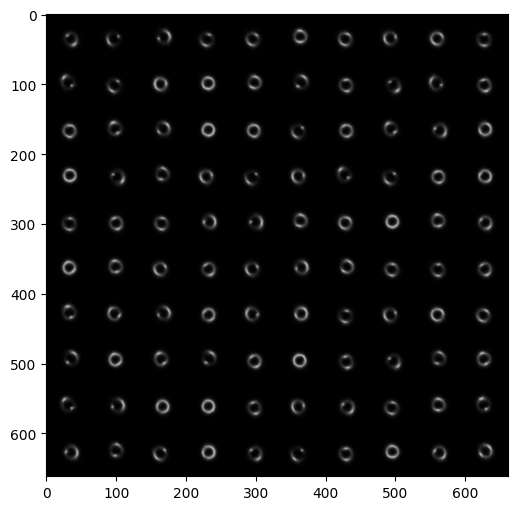

In [28]:
gen_img = sample(model = generator, checkpoint = None)

Text(0.5, 1.0, 'losses')

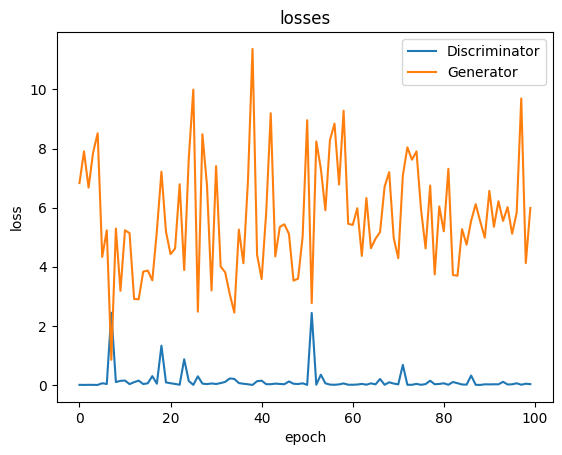

In [29]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('losses' )

Text(0.5, 1.0, 'Scores')

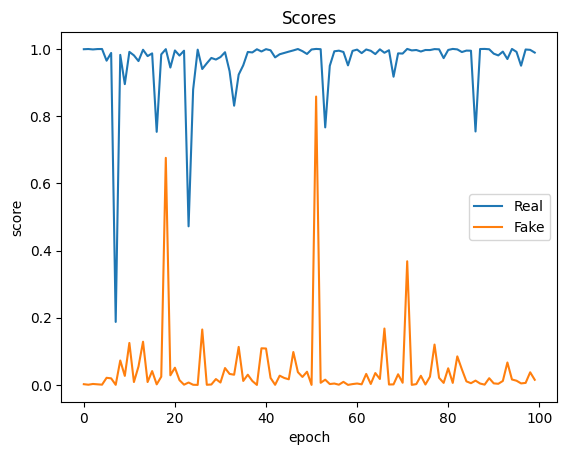

In [30]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores')

In [32]:
fid_score = calc_fid(generator)
print("The FID score that I obtained for 1000 images with 2048 features from pretrained inception network is ", fid_score.item())


ModuleNotFoundError: FrechetInceptionDistance metric requires that `Torch-fidelity` is installed. Either install as `pip install torchmetrics[image]` or `pip install torch-fidelity`.

: 